# Deconvolution of bulk RNA-Seq data into single-cell RNA-Seq data.

The purpose of this work is to resolve the heterogeneous transcriptome derived from bulk RNA-Seq into single cell RNA-Seq (scRNA-Seq) using a novel deep-learning deconvolution method, namely Bulk2space (Research paper: https://www.nature.com/articles/s41467-022-34271-z python package: https://github.com/ZJUFanLab/bulk2space)

Briefly, a β-variational autoencoder is used as a deep generative model to deconvolute the bulk transcriptome. The model is trained on existing scRNA-Seq data from the tissue/organ of interest. Subsequently, the newly deconvoluted dataset is spatially resolved using the a spatial transcritomics dataset as reference.

This jupyter notebook cover the analysis step-by-step from bulk RNA-Seq deconvolution to spatially resolved results.

**NOTE**: Generation and preprocessing of input files required by Bulk2space is described in detail in the R scripts "Processing sc_data and meta" and "Processing st_data and meta".

### Overview
- Setup
- Deconvolution
- Results: the single cell composition of the mouse heart
- Spatial mapping
- Results: spatially resolved cardiac cells


## Setup
First, we import all modules needed and initiate the Bulk2space instance.

In [1]:
# Import modules
from dataclasses import dataclass
from unicodedata import name
import scanpy
import pandas as pd
import numpy as np
import matplotlib.colors as clr
import matplotlib.pyplot as plt
import scipy.stats as pearsonr

import bulk2space
from bulk2space import Bulk2Space

model = Bulk2Space()

## Deconvolution
To deconvolute bulk RNA-seq, the `.train_vaw_and_generate()` method is used. The parameters used for deconvolution of the control and knockout groups is described in **"Deconvolution paramenters.txt**". The Bulk2space requires five formatted datasetes as input:
1. Bulk-seq Normalized Data - This is the bulk transcriptome to deconvolute
2. scRNA-seq Normalized Data - This is a cell x gene count matrix
3. scRNA-seq Annotation Data - This provides cell type information
4. Spatial Transcriptomics Normalized Data - This is a cell x gene count matrix of a spatial transcriptome
5. Spatial Transcriptomics Coordinates Data - This provides the spatial position of each cell

All input files were generated in R as mentioned above. "Bulk-seq Normalized Data" was generated as described in the python script "Bulk transcriptome data cleaning".

Further details of input data format can be found here https://github.com/ZJUFanLab/bulk2space/blob/main/tutorial/handbook.md. 

In [2]:
generate_sc_meta, generate_sc_data = model.train_vae_and_generate(
    input_bulk_path="Clean_CKO_bulk.csv", # Bulk transcriptome
    input_sc_data_path="AC_sc_data.csv", # scRNA-Seq count matrix
    input_sc_meta_path="AC_sc_meta.csv", # scRNA-Seq annotations
    input_st_data_path="AC_st_data.csv", # Spatial transcriptomics count matrix
    input_st_meta_path="AC_st_meta.csv", # Spatial transcriptomics coordinates
    ratio_num=1,
    top_marker_num=500,
    gpu=0,
    batch_size=512,
    learning_rate=1e-4,
    hidden_size=256,
    epoch_num=3500,
    vae_save_dir="Singlecell/save model",
    vae_save_name="longAxis_CKO_vae",
    generate_save_dir="Singlecell/outputfolder",
    generate_save_name="longAxis_CKO",
)

loading data......
load data done!
3482
If there are duplicated gene names, they will be shown below:
begin vae training...


Train Epoch: 3499: 100%|██████████| 3500/3500 [22:50<00:00,  2.55it/s, loss=0.6294, min_loss=0.6262]


min loss = 0.6262150332331657
vae training done!


generating:  40%|████      | 1352/3375.0 [00:00<00:00, 12515.64it/s]

save trained vae in Singlecell/save model\longAxis_CKO_vae.pth.
generating....


generating: 100%|██████████| 3375/3375.0 [00:00<00:00, 11402.78it/s]


generated done!
saving to Singlecell/outputfolder\longAxis_CKO_sc_celltype.csv and Singlecell/outputfolder\longAxis_CKO_sc_data.csv.


## Results: the single cell composition of the mouse heart
Once the deconvolution is complete we will obtain the scRNA-Seq of the initial bulk transcriptome. The time required to complete the deconvolution is dependent on the GPU used. All analysis and pre-procesing was performed with an Nvidia RTX 3070 Founders Edition. 

Having an scRNA-Seq dataset, we can look at the cell populations and their distribution. 

First, we will load the data using the tools provided with Bulk2space.

In [4]:
# load input sc data
input_data = bulk2space.utils.load_data(
    input_bulk_path='Clean_CKO_bulk.csv',
    input_sc_data_path='AC_sc_data.csv',
    input_sc_meta_path='AC_sc_meta.csv',
    input_st_data_path='AC_st_data.csv',
    input_st_meta_path='AC_st_meta.csv'
)

loading data......
load data done!


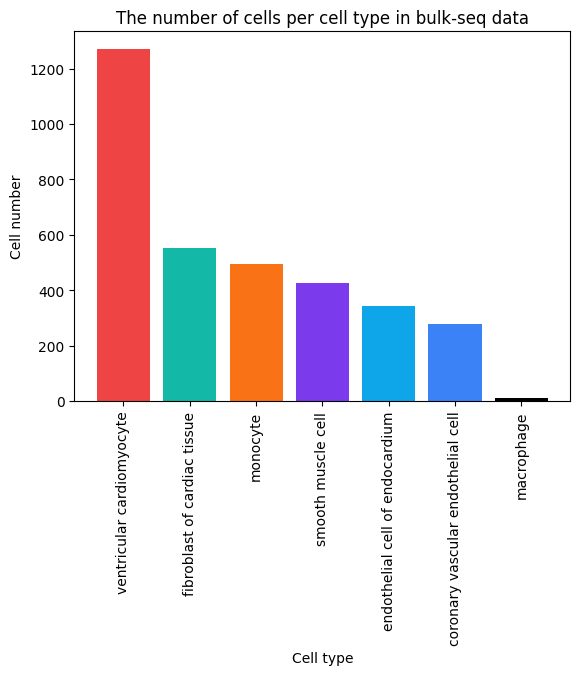

In [5]:
# The number of cells per cell type in deconvoluted bulk-seq data
ct_stat = pd.DataFrame(generate_sc_meta['Cell_type'].value_counts())
ct_name = list(ct_stat.index)
ct_num = list(ct_stat['Cell_type'])
color = ["#EF4444", "#14B8A6", '#F97316', "#7C3AED", "#0EA5E9", '#3B82F6',
         '#000000', '#10B981', '#EC4899', "#7DD3FC", "#F472B6", "#D946EF"]
plt.bar(ct_name, ct_num, color=color)
plt.xticks(ct_name, ct_name, rotation=90)
plt.title("The number of cells per cell type in bulk-seq data")
plt.xlabel("Cell type")
plt.ylabel("Cell number")
plt.show()

The most abundant population is cardimyocytes.

We can then determine the correlation in the expression of marker genes between the reference scRNA-seq data and the generated scRNA-seq data. This way we can understand if computationally generated cells are a truthful representation of real ones.

In [19]:
# Calculate 200 marker genes of each cell type
sc = scanpy.AnnData(input_data['input_sc_data'].T)
sc.obs = input_data['input_sc_meta'][['Cell_type']]
scanpy.tl.rank_genes_groups(sc, 'Cell_type', method='wilcoxon')
marker_df = pd.DataFrame(sc.uns['rank_genes_groups']['names']).head(200)
marker = list(np.unique(np.ravel(np.array(marker_df))))

# Calculate the mean expression of 200 marker genes of real cells
sc_marker = input_data['input_sc_data'].loc[marker, :].T
sc_marker['Cell_type'] = input_data['input_sc_meta']['Cell_type']
sc_marker_mean = sc_marker.groupby('Cell_type')[marker].mean()

# Calculate the mean expression of 200 marker genes of deconvoluted cells
generate_sc_meta.index = list(generate_sc_meta['Cell'])
generate_sc_data_new = generate_sc_data.T
new_header = generate_sc_data_new.iloc[0]
generate_sc_data_new = generate_sc_data_new[1:]
generate_sc_data_new['Cell_type'] = generate_sc_meta['Cell_type']

generate_sc_marker_mean = generate_sc_data_new.groupby('Cell_type')[
    marker].mean()

# Keep mutual marker genes
intersect_cell = list(set(sc_marker_mean.index).intersection(
    set(generate_sc_marker_mean.index)))
generate_sc_marker_mean = generate_sc_marker_mean.loc[intersect_cell]
sc_marker_mean = sc_marker_mean.loc[intersect_cell]

# Calculate correlation
sc_marker_mean = sc_marker_mean.T
generate_sc_marker_mean = generate_sc_marker_mean.T
coeffmat = np.zeros(
    (sc_marker_mean.shape[1], generate_sc_marker_mean.shape[1]))
for i in range(sc_marker_mean.shape[1]):
    for j in range(generate_sc_marker_mean.shape[1]):
        corrtest = pearsonr.pearsonr(sc_marker_mean[sc_marker_mean.columns[i]],
                                     generate_sc_marker_mean[generate_sc_marker_mean.columns[j]])
        coeffmat[i, j] = corrtest[0]

rf_ct = list(sc_marker_mean.columns)
generate_ct = list(generate_sc_marker_mean.columns)



Plot the correlation:

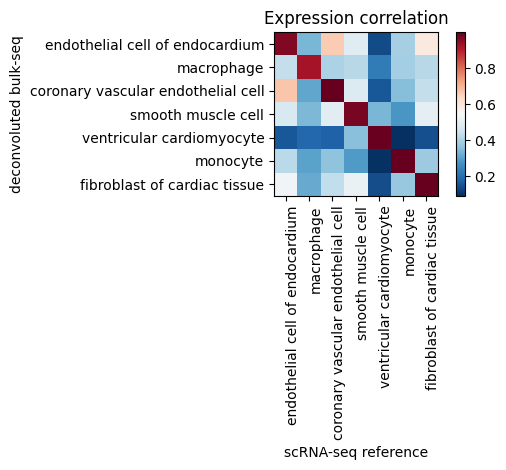

,C_1,C_2,C_3,C_4,C_5,C_6,C_7,C_8,C_9,C_10,...,C_3366,C_3367,C_3368,C_3369,C_3370,C_3371,C_3372,C_3373,C_3374,C_3375
Pten,0.0,0.0,0.833437,0.124622,0.044152,0.274603,0.000000,0.0,1.159436,0.470757,...,0.808747,0.0,0.0,0.0,0.0,0.349108,0.0,0.0,0.0,0.802298
Znrf1,0.0,0.0,0.096640,0.000000,0.000000,0.857561,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
Arc,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
Mbtps2,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
Gbgt1,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Ormdl1,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
Tpbg,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
Dnase1l1,0.0,0.0,0.765794,0.273593,0.334491,0.935338,0.000000,0.0,2.060165,0.123372,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.362248
Lrmp,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.234501,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000


In [23]:
# Plot the results as a heatmap
fig, ax = plt.subplots()
im = ax.imshow(coeffmat, cmap='RdBu_r')
ax.set_xticks(np.arange(len(rf_ct)))
ax.set_xticklabels(rf_ct)
ax.set_yticks(np.arange(len(generate_ct)))
ax.set_yticklabels(generate_ct)
plt.xlabel("scRNA-seq reference")
plt.ylabel("deconvoluted bulk-seq")
plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")
plt.colorbar(im)
ax.set_title("Expression correlation")
fig.tight_layout()
plt.show()

We can see that the "artificially" generated cells are biologically close to their real counterpart. This shows that:
1. The deconvolution algorithm can generate biologically feasible cells.
2. It is possible to draw biological conclusions by analysing cells generated with A.I.

For more extensive model validation please refer to the author's original paper of Bulk2space (https://www.nature.com/articles/s41467-022-34271-z).

## Spatial mapping
Next, we can employ Bulk2space to map the newly resolved scRNA-Seq dataset onto a tissue section. This way we can add spatial information to gene expression. Briefly, each cell is mapped to a specific location within the tissue based on its genetic signature.

We will use the `.train_df_and_spatial_deconvolution()` method of Bulk2space. Parameters used are described in "Deconvolution parameters.txt".

In [26]:
if __name__ == "__main__": # Remove this line if running on UNIX
    df_meta, df_data = model.train_df_and_spatial_deconvolution(
        generate_sc_meta,
        generate_sc_data,
        input_st_data_path="AC_st_data.csv",
        input_st_meta_path="AC_st_meta.csv",
        spot_num=200,
        cell_num=5,
        df_save_dir="Singlecell/save_model/",
        df_save_name="LongAxis_CKO_df",
        map_save_dir="Singlecell/result_LongAxis",
        map_save_name="LongAxis_CKO_map",
        top_marker_num=500,
        marker_used=True,
        k=10
    )

## Results: spatially resolved cardiac cells
Once the spatial mapping is complete we will be able to evaluate where individual cells of the heart are located. 

Unlike conventional methods of spatial transcriptomics, Bulk2space allows to visualise the cells at single-cell resolution.

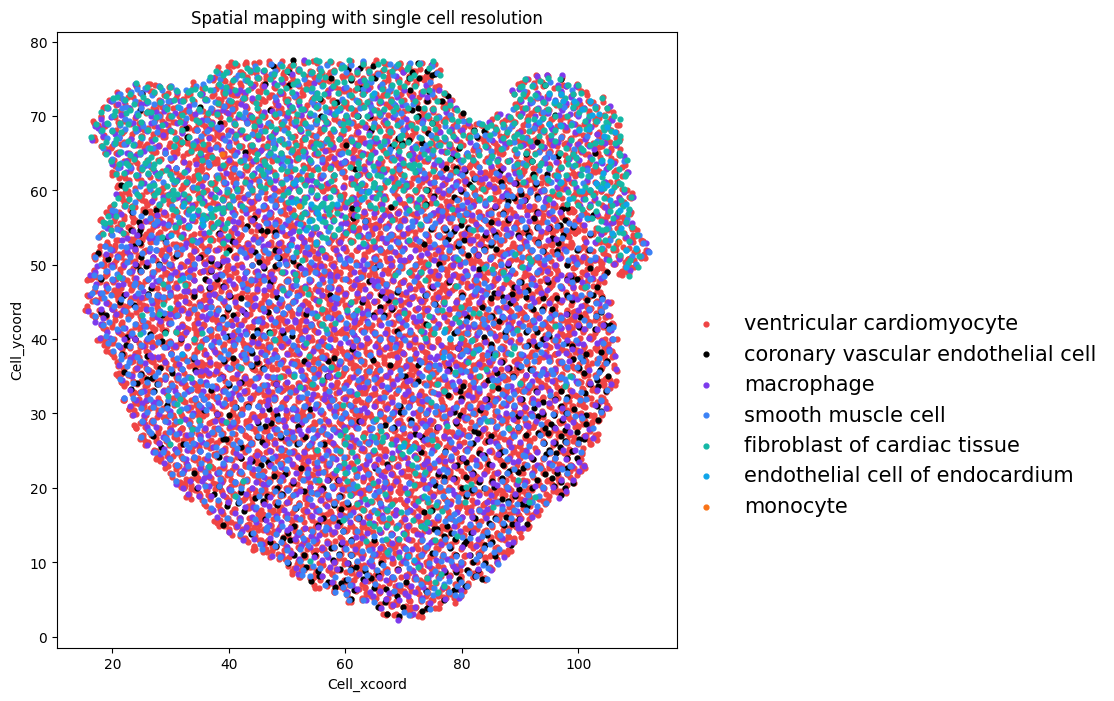

In [35]:
# Spatial mapping with single cell resolution
ct_type = list(df_meta["Cell_type"].unique())
color = [
    "#EF4444",
    "#000000",
    "#7C3AED",
    "#3B82F6",
    "#14B8A6",
    "#0EA5E9",
    "#F97316",
    "#7C3AED",
]

fig, ax = plt.subplots(figsize=(8, 8))
for i in range(len(ct_type)):
    ax.scatter(
        df_meta.loc[df_meta.Cell_type == ct_type[i], "Cell_xcoord"],
        df_meta.loc[df_meta.Cell_type == ct_type[i], "Cell_ycoord"],
        color=color[i],
        label=ct_type[i],
        s=12,
    )
plt.title("Spatial mapping with single cell resolution")
plt.xlabel("Cell_xcoord")
plt.ylabel("Cell_ycoord")
plt.legend(bbox_to_anchor=(1, 0.2), loc=3,
           borderaxespad=0, frameon=False, fontsize=15)
plt.show()

With spatial information added, it is possible to examine the spatial expression patterns of marker genes. Their expression is expected to be consisted with the location of the cells they are found into.

Alternatively, one can assess the spatial expression of any other gene of interest and infere whether pathological genes are expressed in specific areas of the heart.

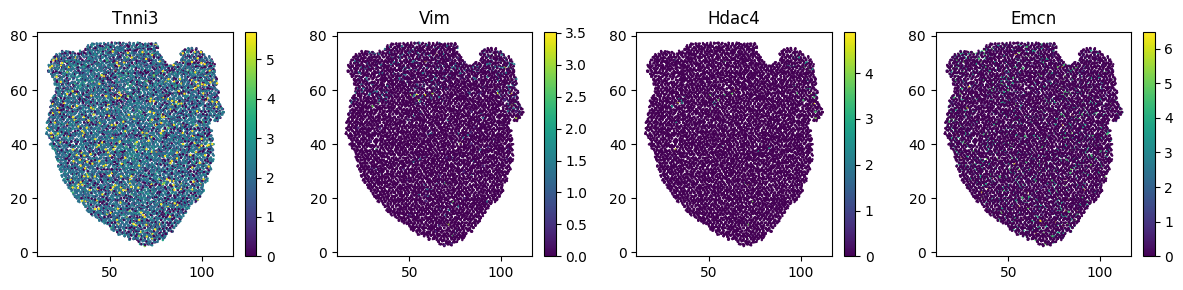

In [37]:
# Gene expression at single cell resolution
plot = df_meta
plot.index = list(plot["Cell"])

# Each gene is a marker gene of a cardiac cell
gene = ["Tnni3", "Vim", "Emcn", "Acta2"]
plot[gene] = df_data.T[gene]
xcoord = np.array(plot["Cell_xcoord"])
ycoord = np.array(plot["Cell_ycoord"])
gene1 = np.array(plot["Tnni3"]) # Cardiomyocyte marker
gene2 = np.array(plot["Vim"]) # Fibroblast marker
gene3 = np.array(plot["Emcn"]) # Endocardial marker
gene4 = np.array(plot["Acta2"]) # Smooth muscle cell marker

fig, axs = plt.subplots(1, 4, figsize=(12, 3))

a = axs[0].scatter(xcoord, ycoord, s=0.5, cmap="viridis", c=gene1)
fig.colorbar(a, ax=axs[0])
axs[0].set_title("Tnni3") 

b = axs[1].scatter(xcoord, ycoord, s=0.5, cmap="viridis", c=gene2)
fig.colorbar(b, ax=axs[1])
axs[1].set_title("Vim")

c = axs[2].scatter(xcoord, ycoord, s=0.5, cmap="viridis", c=gene3)
fig.colorbar(c, ax=axs[2])
axs[2].set_title("Hdac4")

d = axs[3].scatter(xcoord, ycoord, s=0.5, cmap="viridis", c=gene4)
fig.colorbar(d, ax=axs[3])
axs[3].set_title("Emcn")

plt.tight_layout()
plt.show()

It may be more readable to plot the spatial decovnolution results at spot-level resolution. To do so, we calculate the cell type proportion for each spot and then we aggregate the gene expression of cells per spot.

In [38]:
# Spot-level resolution
# Calculate cell type proportion per spot
prop = df_meta[["Cell", "Cell_type", "Spot"]].pivot_table(
    index=["Spot"], columns=["Cell_type"], aggfunc="count", values="Cell", fill_value=0
)
prop = prop.div(prop.sum(axis=1), axis=0)
prop.columns = pd.Index(list(prop.columns))
prop["Spot_xcoord"] = np.array(
    df_meta.pivot_table(index=["Spot"])["Spot_xcoord"])
prop["Spot_ycoord"] = np.array(
    df_meta.pivot_table(index=["Spot"])["Spot_ycoord"])

# Aggregate gene expression per spot
pred_spot_new = df_data.T
genes = pred_spot_new.columns
pred_spot_new["Spot"] = df_meta["Spot"]
pred_spot_mean = pred_spot_new.groupby("Spot")[genes].mean()

Then we plot the results

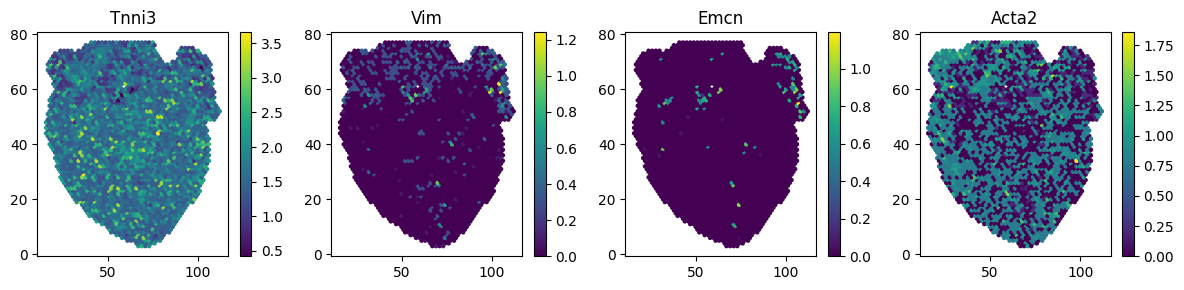

In [40]:
# Plot gene expression proportion
spot_x = np.array(prop["Spot_xcoord"])
spot_y = np.array(prop["Spot_ycoord"])
g1 = np.array(pred_spot_mean["Tnni3"])
g2 = np.array(pred_spot_mean["Vim"])
g3 = np.array(pred_spot_mean["Emcn"])
g4 = np.array(pred_spot_mean["Acta2"])

fig, axs = plt.subplots(1, 4, figsize=(12, 3))

a = axs[0].scatter(spot_x, spot_y, s=5, cmap="viridis", c=g1)
fig.colorbar(a, ax=axs[0])
axs[0].set_title("Tnni3")

b = axs[1].scatter(spot_x, spot_y, s=5, cmap="viridis", c=g2)
fig.colorbar(b, ax=axs[1])
axs[1].set_title("Vim")

d = axs[2].scatter(spot_x, spot_y, s=5, cmap="viridis", c=g3)
fig.colorbar(d, ax=axs[2])
axs[2].set_title("Emcn")

e = axs[3].scatter(spot_x, spot_y, s=5, cmap="viridis", c=g4)
fig.colorbar(e, ax=axs[3])
axs[3].set_title("Acta2")

plt.tight_layout()
plt.show()

We can see how different genes have different spatial distributions.

We can also look at cell type proportions at spot level and check whether they co-localise with their marker gene.

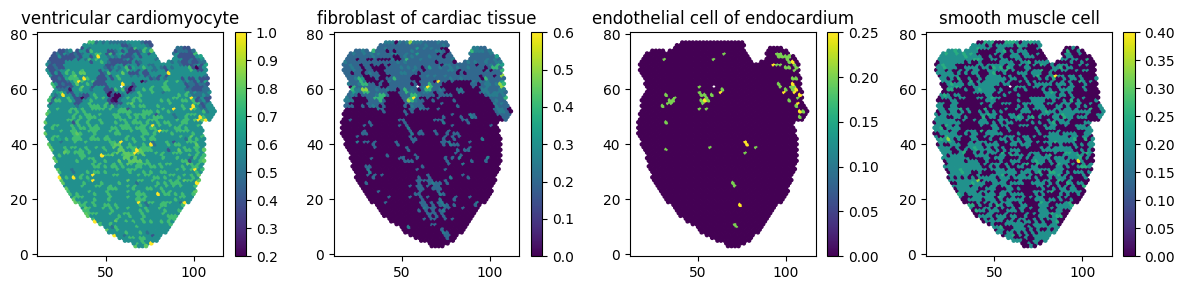

In [42]:
# plot cell type proportion
# Acinar cells; Cancer clone A; Cancer clone B; Ductal
spot_x = np.array(prop["Spot_xcoord"])
spot_y = np.array(prop["Spot_ycoord"])
cell1 = np.array(prop["ventricular cardiomyocyte"])
cell2 = np.array(prop["fibroblast of cardiac tissue"])
cell3 = np.array(prop["endothelial cell of endocardium"])
cell4 = np.array(prop["smooth muscle cell"])

fig, axs = plt.subplots(1, 4, figsize=(12, 3))

a = axs[0].scatter(spot_x, spot_y, s=5, cmap="viridis", c=cell1)
fig.colorbar(a, ax=axs[0])
axs[0].set_title("ventricular cardiomyocyte")

b = axs[1].scatter(spot_x, spot_y, s=5, cmap="viridis", c=cell2)
fig.colorbar(b, ax=axs[1])
axs[1].set_title("fibroblast of cardiac tissue")

c = axs[2].scatter(spot_x, spot_y, s=5, cmap="viridis", c=cell3)
fig.colorbar(c, ax=axs[2])
axs[2].set_title("endothelial cell of endocardium")

e = axs[3].scatter(spot_x, spot_y, s=5, cmap="viridis", c=cell4)
fig.colorbar(e, ax=axs[3])
axs[3].set_title("smooth muscle cell")

plt.tight_layout()
plt.show()

As expected, each cell marker co-localises with the key cell expressing it.